<a href="https://colab.research.google.com/github/rmkenv/newsletter/blob/main/newsletter9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2774154688.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range('2024-06-01', periods=720, freq='H')


Test MAE for net load prediction: 6.23 kWh


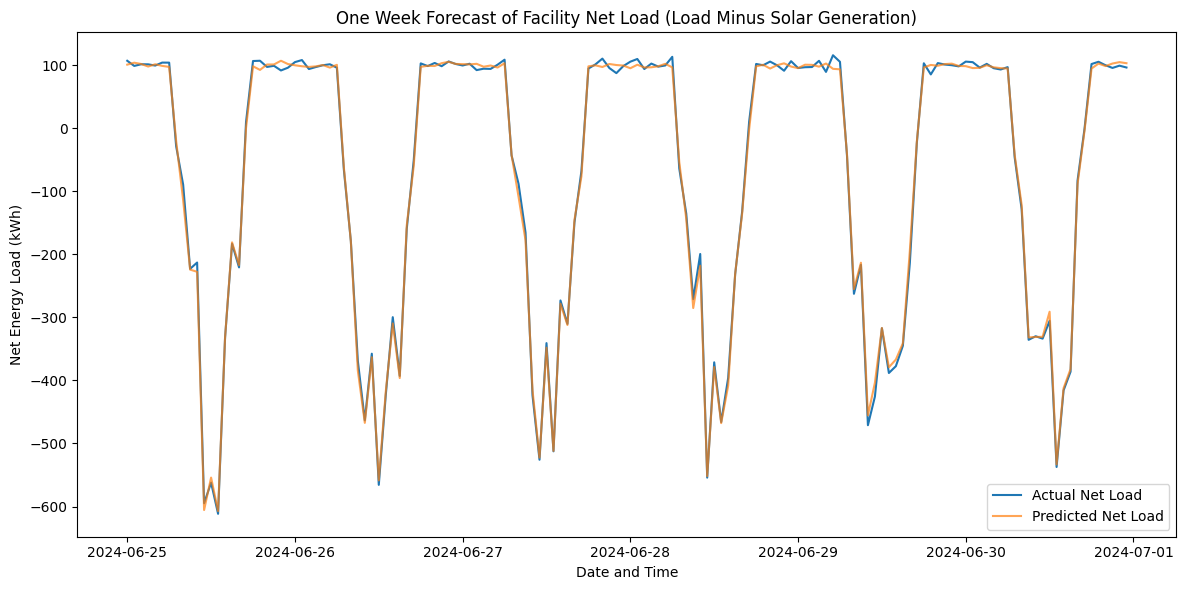

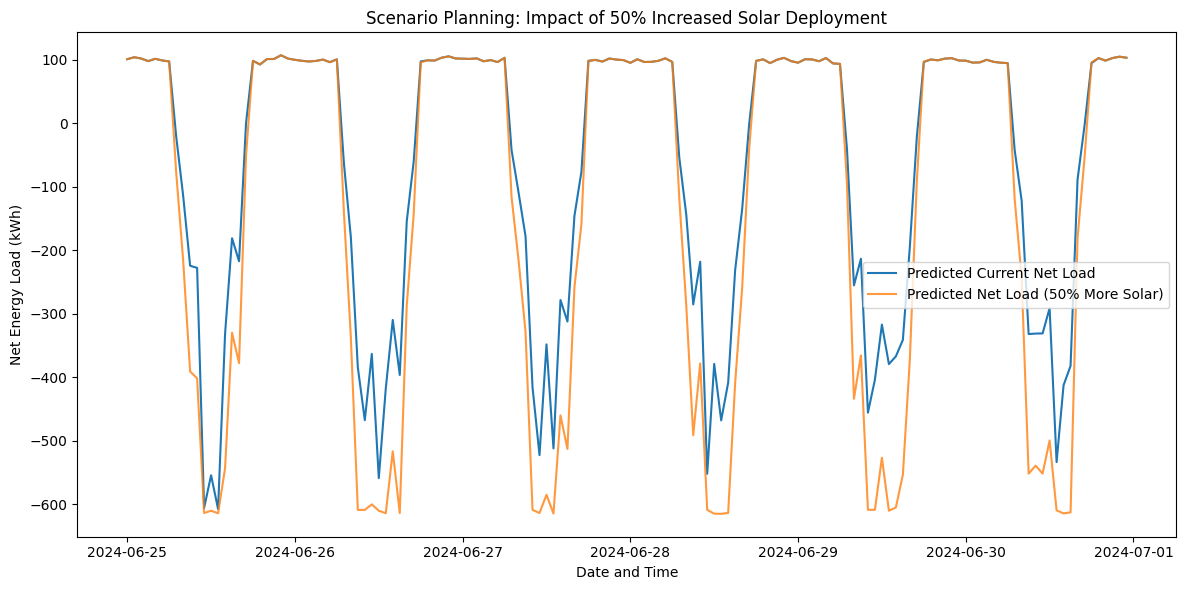

In [4]:
#Newsletter 1.9
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Generate hourly timestamps for one month
hours = pd.date_range('2024-06-01', periods=720, freq='H')

# Simulate outdoor temperature with seasonal and daily patterns plus noise
temperature = (25
               + 8 * np.sin((hours.dayofyear - 172) * 2 * np.pi / 365)
               + 5 * np.sin(hours.hour * np.pi / 12)
               + np.random.normal(0, 1.5, len(hours)))

# Simulate occupancy: work hours on weekdays (1 if occupied, else 0)
occupancy = ((hours.dayofweek < 5) & (hours.hour >= 8) & (hours.hour < 18)).astype(int)

# Simulate renewable generation (solar PV) profile: zero at night, peak midday, variability with cloud cover
solar_irradiance = np.maximum(0, 1000 * np.sin((hours.hour - 6) * np.pi / 12))  # Simplified clear-day solar
cloud_cover_factor = 1 - 0.5 * np.random.rand(len(hours))  # Random cloud cover between 0.5 and 1
solar_generation = solar_irradiance * cloud_cover_factor  # Adjusted for cloudiness

# HVAC load based on temperature and occupancy
base_load = 100
cooling_load = np.maximum(temperature - 22, 0) * 2.0 * occupancy
heating_load = np.maximum(18 - temperature, 0) * 1.8 * occupancy
plug_load = 10 * occupancy

# Total facility load before renewable offset
total_load = base_load + heating_load + cooling_load + plug_load + np.random.normal(0, 5, len(hours))

# Net load after onsite solar generation offset
net_load = total_load - solar_generation * 0.75  # Assume 75% of solar generation offsets facility load

# Compile data into DataFrame
df = pd.DataFrame({
    'datetime': hours,
    'temperature': temperature,
    'occupancy': occupancy,
    'hour': hours.hour,
    'dayofweek': hours.dayofweek,
    'solar_generation': solar_generation,
    'total_load': total_load,
    'net_load': net_load
})

# Define features for forecasting net load (load after renewables)
features = ['temperature', 'occupancy', 'hour', 'dayofweek', 'solar_generation']
split_idx = int(len(df) * 0.8)

X_train = df[features].iloc[:split_idx]
y_train = df['net_load'].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df['net_load'].iloc[split_idx:]

# Train Random Forest regressor to predict net load
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_net_load = model.predict(X_test)

# Evaluate model accuracy
mae = mean_absolute_error(y_test, predicted_net_load)
print(f'Test MAE for net load prediction: {mae:.2f} kWh')

# Visualize one week actual vs predicted net load
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'].iloc[split_idx:split_idx + 168], y_test.iloc[:168], label='Actual Net Load')
plt.plot(df['datetime'].iloc[split_idx:split_idx + 168], predicted_net_load[:168], label='Predicted Net Load', alpha=0.7)
plt.xlabel('Date and Time')
plt.ylabel('Net Energy Load (kWh)')
plt.title('One Week Forecast of Facility Net Load (Load Minus Solar Generation)')
plt.legend()
plt.tight_layout()
plt.show()

# Scenario Planning: Impact of Increasing Solar Capacity by 50%
solar_generation_future = solar_generation * 1.5
net_load_future = total_load - solar_generation_future * 0.75

df_future = df.copy()
df_future['solar_generation'] = solar_generation_future
df_future['net_load_future'] = net_load_future

# Predict net load with increased solar capacity
X_future = df_future[features].iloc[split_idx:]
predicted_net_load_future = model.predict(X_future)

# Visualize comparison of current vs future net load forecasts for one week
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'].iloc[split_idx:split_idx + 168], predicted_net_load[:168], label='Predicted Current Net Load')
plt.plot(df_future['datetime'].iloc[split_idx:split_idx + 168], predicted_net_load_future[:168], label='Predicted Net Load (50% More Solar)', alpha=0.8)
plt.xlabel('Date and Time')
plt.ylabel('Net Energy Load (kWh)')
plt.title('Scenario Planning: Impact of 50% Increased Solar Deployment')
plt.legend()
plt.tight_layout()
plt.show()
